# Linear Regression Cross Validation

In [1]:
# Use to access Earth Engine API
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=yIljcllnh2NdVnzXZE7aMrbsBma_M0X78A62ybcWqkA&tc=f4ItU9YFatS2nCakfBjq2xKbidYfREgGpWSE6B43mcg&cc=U_0jYHtqKMul5vZpNZNuyCOfMWBAloTQo-Njl8WqxaA

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXmctRXC6RIaB5wh7oJt2ObmoqJRosfgzSyO18vJlUSuwr0PddTHg6o

Successfully saved authorization token.


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

### Import 10 folds of data. I split this up in advance to keep the folds consistent across all models.

In [3]:
# import the 10-folds of training and validation data
f0 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f0')
f1 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f1')
f2 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f2')
f3 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f3')
f4 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f4')
f5 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f5')
f6 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f6')
f7 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f7')
f8 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f8')
f9 = ee.FeatureCollection('users/aspenjkmorgan/k_folds/f9')

In [4]:
# create 10 training sets (train0 contains all folds except f0)
train0 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train1 = ee.FeatureCollection([f0, f2, f3, f4, f5, f6, f7, f8, f9]).flatten()
train2 = ee.FeatureCollection([f1, f0, f3, f4, f5, f6, f7, f8, f9]).flatten()
train3 = ee.FeatureCollection([f1, f2, f0, f4, f5, f6, f7, f8, f9]).flatten()
train4 = ee.FeatureCollection([f1, f2, f3, f0, f5, f6, f7, f8, f9]).flatten()
train5 = ee.FeatureCollection([f1, f2, f3, f4, f0, f6, f7, f8, f9]).flatten()
train6 = ee.FeatureCollection([f1, f2, f3, f4, f5, f0, f7, f8, f9]).flatten()
train7 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f0, f8, f9]).flatten()
train8 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f0, f9]).flatten()
train9 = ee.FeatureCollection([f1, f2, f3, f4, f5, f6, f7, f8, f0]).flatten()

# map training data to validation data for each fold
folds = {
    train0: f0,
    train1: f1,
    train2: f2,
    train3: f3,
    train4: f4,
    train5: f5,
    train6: f6,
    train7: f7,
    train8: f8,
    train9: f9
}

### Model and Helper Functions

In [5]:
def applyLinearModel(feature):
  pm_cal = ee.Number(feature.get('aod')).multiply(slope).add(yint)
  return feature.set('pm_cal', pm_cal)

def sqResiduals(feature):
  residual = ee.Number(feature.get('pm_cal')).subtract(ee.Number(feature.get('pm25')))
  # Return the feature with the squared difference set to the 'diff' property.
  return feature.set('sq_residual', residual.pow(2))

def sqDifference(feature):
  diff = ee.Number(feature.get('pm25')).subtract(mean)
  return feature.set('sq_diff', diff.pow(2))



### Calculate $R^2$ and RMSE and plot residuals for each fold

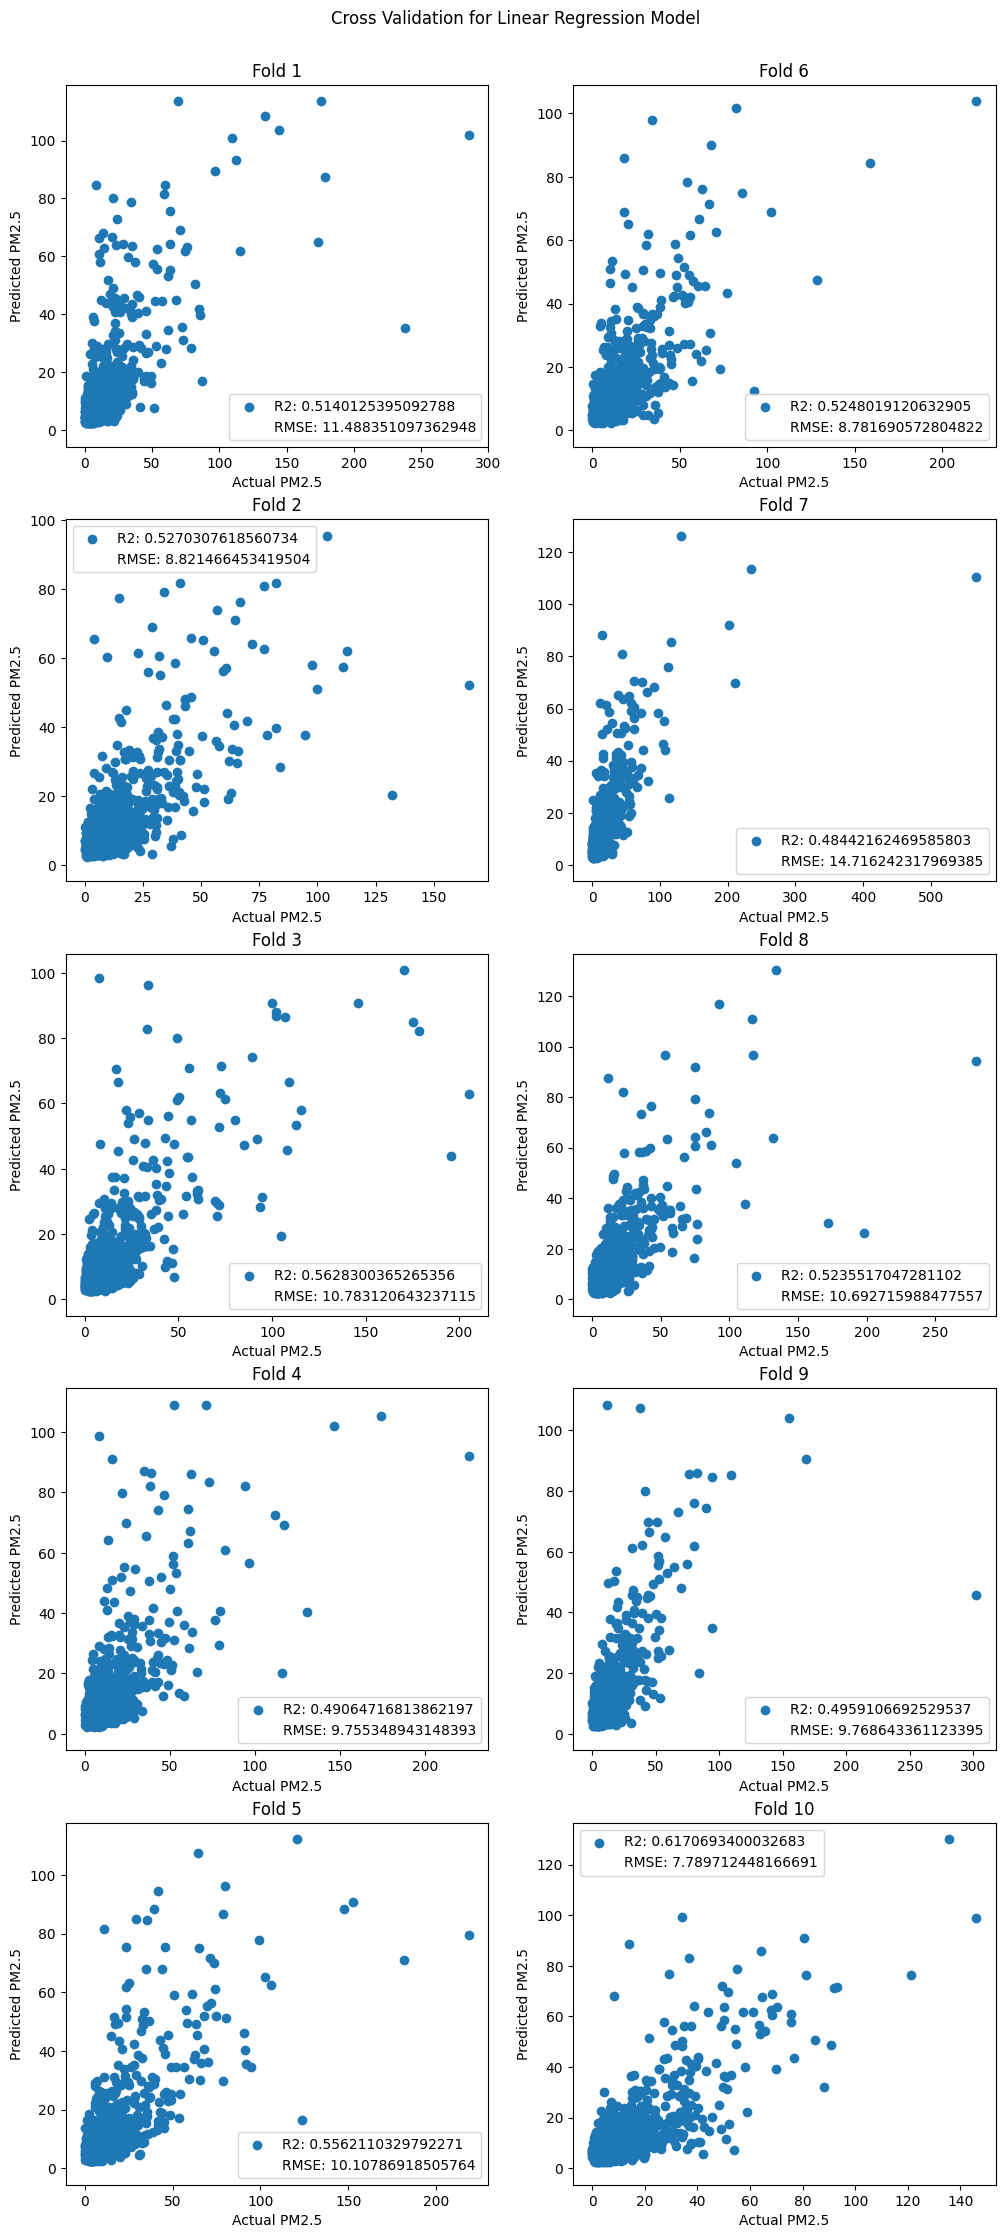

In [48]:
# prepare for graphs
fig, ax = plt.subplots(5, 2, figsize=(12, 25))
fig.suptitle('Cross Validation for Linear Regression Model')
fig.subplots_adjust(top=0.95)

all_folds_data = []
count = 0
for train in folds:
  training = train
  validation = folds[train]

  # create linear fit model and get coeffiecients
  lf = training.reduceColumns(**{
    'reducer': ee.Reducer.linearFit(),
    'selectors': ['aod', 'pm25']})
  yint = lf.get('offset')
  slope = lf.get('scale')

  # apply the model to the validation data
  current_fold_fc = ee.FeatureCollection(validation.map(applyLinearModel))

  # Compute the square residuals of computed and actual pm25
  rss_col = current_fold_fc.map(sqResiduals)
  rss = ee.Number(rss_col.aggregate_sum('sq_residual'))
  mean = ee.Number(current_fold_fc.aggregate_mean('pm25'))
  tss = ee.Number(current_fold_fc.map(sqDifference).aggregate_sum('sq_diff'))
  r2 = ee.Number(1).subtract(rss.divide(tss))
  rmse = ee.Number(rss_col.reduceColumns(ee.Reducer.mean(), ['sq_residual']).get('mean')).sqrt()

  new_feature = ee.Feature(None, {'fold': count, 'val_rmse': rmse, 'r2': r2})
  all_folds_data.append(new_feature)

  # plot the residuals
  pm = current_fold_fc.reduceColumns(ee.Reducer.toList(), ['pm25']).get('list').getInfo()
  pm_pred = current_fold_fc.reduceColumns(ee.Reducer.toList(), ['pm_cal']).get('list').getInfo()
  residuals = pd.DataFrame({'pm25': pm, 'pm_cal': pm_pred})
  ax[count%5][count//5].scatter(residuals['pm25'], residuals['pm_cal'], label='R2: ' + str(r2.getInfo()))
  ax[count%5][count//5].set_title('Fold ' + str(count+1))
  ax[count%5][count//5].set_xlabel('Actual PM2.5')
  ax[count%5][count//5].set_ylabel('Predicted PM2.5')
  ax[count%5][count//5].scatter(0, 0, alpha=0, label='RMSE: ' + str(rmse.getInfo()))
  ax[count%5][count//5].legend()

  count += 1

# combine data from all folds into one feature collection. Each
# fold will have a different starting index number
data = ee.FeatureCollection(all_folds_data)

# save residuals plot
plt.savefig("cv_linear_reg.pdf", bbox_inches='tight')

In [9]:
cv_rmse = data.aggregate_mean('val_rmse')
cv_r2 = data.aggregate_mean('r2')
print(cv_rmse.getInfo())
print(cv_r2.getInfo())

10.270516101076746
0.5296486789753218
